In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from data_preprocessing import get_regions, enumerate_dates
from mechanistic_model import ODE_model, prepare_ODE_model_data, fit_ODE_model
from scipy.integrate import odeint
from pygom import SimulateOde
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
# setting up the plotting
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12 
random.seed = 1

# Simulating regional epidemics

The underlying ODE model can be found in 'mechanistic_model.py'. This ha sbeen constructed using Pygom. ABC fitting is used to provide a distribution of parameterisations.

In it's current form, the SEIUR model used to generate simulations can not be used to fit to fatalities or ICU admissions, however fitting to hospitalisations or confirmed cases can be acheived by stating 'cases' or 'hospitalisations' as the 'fit_to' parameter.

In [2]:
# Dictionary for assigning populations
DE_pop_dict = {'BW':11.07e6, 'BY':13.08e6, 'BE':3.64e6, 'HE':6.27e6, 'NI':7.98e5, 'NW':17.93e6, 'RP':4.08e6}
reg_pop_dict = {'IT':IT_pop_dict, 'ES':ES_pop_dict, 'US':US_pop_dict, 'DE':DE_pop_dict}
DE_int_dict = {'BE':11, 'BW':22, 'BY':46, 'HE':14, 'NI':13, 'NW':18, 'RP':14}

In [3]:
def find_weights(data):
    weights = [1]
    
    for x in range(1, len(data)):
        if data[x] == 0:
            weight = 0.00001
        else:
            weight = (data[x] - data[x-1])/data[x]
        
        if weight == 0:
            weight = 0.00001 # Note weights can not be zero
        weights.append(weight)
    return weights


def fit_poisson(endog, exog, weights):
    poiss = sm.GLM(endog, exog, family=sm.families.Poisson(), weights=weights).fit()
    lambdas = poiss.mu
    df_train = pd.DataFrame(columns=['BB_count', 'BB_lambda', 'Aux_OLS_dep'])
    df_train['BB_count']=endog
    df_train['BB_lambda']=lambdas
    return df_train


def fit_auxiliary_OLS(df_train):
    df_train['Aux_OLS_dep'] = df_train.apply(lambda x:((x['BB_count']- x['BB_lambda'])**2 - x['BB_count'])/ x['BB_lambda'], axis=1)   
    ols_expr = """Aux_OLS_dep ~ BB_lambda - 1"""
    aux_olsr_results = smf.ols(ols_expr, df_train).fit()
    return aux_olsr_results.params.BB_lambda


def estimate_over_dispersion(data, weights):
    endog = data
    exog = sm.add_constant(np.linspace(0, len(data)-1, len(data)))
    df_train = fit_poisson(endog, exog, weights)
    alpha = fit_auxiliary_OLS(df_train)
    k = 1/alpha
    return k

In [5]:
# Set out some parameters:
country = 'DE'
reg = 'BE' # Two letter region code. See reg_pop_dict.
N0 = reg_pop_dict[country][reg]
metric = 'new_cases' # Only 'cases' or 'hospitalisations' currently.
int_date =10
start_day = 0
assumed_lag =5
num_sims = 1000
N_to_fit = int_date + assumed_lag

In [ ]:
N_to_fit

In [ ]:
# Bring in the national data and grab the region of interest. Clean it up a bit too. 
nat_df = pd.read_csv('raw_data/{}_reg_data.csv'.format(country))
reg_data = nat_df[nat_df['region']==reg]
reg_data = reg_data.reset_index(drop=True)
dates = enumerate_dates(reg_data, 'date')
reg_data['date'] = dates

In [33]:
# Prepare the data ready for fitting
fit_data, fit_end_point = prepare_ODE_model_data(df=reg_data, 
                                                 fit_to=metric, 
                                                 N_to_fit=int_date+assumed_lag)
# Estimate over dispersion (k) of fitting data
weights = find_weights(fit_data)
#weights[19:] = [100*x for x in weights[19:]]
k = abs(estimate_over_dispersion(fit_data,weights))
# For lower saxony we need to push the NegBinom towards a poisson loss 
# Due to a change in growth rate directly before school closures
#if reg == 'NI':
#    k=k*2000
print(k)

24.311265509986235


In [35]:
ode_model, fitted_model = fit_ODE_model(full_data=reg_data,
                                        fit_data=fit_data, 
                                        fit_to=metric, 
                                        fit_end_point=fit_end_point,
                                        weights=None,
                                        k=k*np.ones(len(fit_data)),
                                        N0=N0,
                                        generations=15)


<class 'numpy.int64'>
BOX BOUNDS: [(0, 3), (0, 5), (0, 1), (0, 21), (0, 21), (2.5, 40), (2.5, 40), (2.5, 40), (2.5, 40), (2.5, 40), (2.5, 10)]
Using NegBinomLoss
Generation 1 
 tolerance = inf 
 acceptance rate = 100.00%

Generation 2 
 tolerance = 162.65096 
 acceptance rate = 3.34%

Generation 3 
 tolerance = 106.40383 
 acceptance rate = 3.97%

Generation 4 
 tolerance = 86.40622 
 acceptance rate = 3.55%

Generation 5 
 tolerance = 76.57149 
 acceptance rate = 4.02%

Generation 6 
 tolerance = 70.38130 
 acceptance rate = 3.51%

Generation 7 
 tolerance = 67.19638 
 acceptance rate = 2.90%

Generation 8 
 tolerance = 65.59720 
 acceptance rate = 2.67%

Generation 9 
 tolerance = 64.89543 
 acceptance rate = 2.27%

Generation 10 
 tolerance = 64.53788 
 acceptance rate = 2.05%

Generation 11 
 tolerance = 64.29911 
 acceptance rate = 1.41%

Generation 12 
 tolerance = 64.10364 
 acceptance rate = 1.23%

Generation 13 
 tolerance = 63.94439 
 acceptance rate = 1.09%

Generation 14 
 

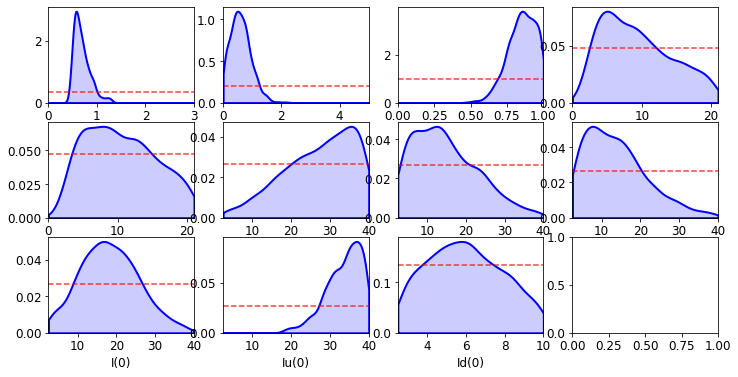

In [36]:
fitted_model.plot_posterior_histograms()

In [37]:
# We now want to run the model with the ascertained ABC posterioirs.
model = ode_model
times = np.linspace(0,len(reg_data),len(reg_data))
curve_idx_dict = {'cases':7, 'hospitalisations':7, 'new_hosps':5, 'new_cases':5}
curve_idx = curve_idx_dict[metric]
# Initialise input variables
n = 0
pred = np.zeros((num_sims,len(times)))
sim = np.zeros((num_sims,len(times)))
I0 = Eb0 = Ec0= Iu0 = R0 = 0
Id_cum0 = Id0 = fit_data[0]
idx1 = 0

for i in range(num_sims):
    print('Simulating posterioir {}'.format(i))
    p_beta, p_gamma,p_kappa, p_delta1, p_delta2, p_Ea0, p_Eb0, p_Ec0, p_I0, p_Iu0, p_Id0 = fitted_model.res[i]
    model.parameters = {'beta':p_beta, 
                        'alpha0':1.6,
                        'alpha1':1.6,
                        'alpha2':1.6,
                        'gamma':p_gamma, 
                        'kappa':p_kappa,
                        'delta1':p_delta1,
                        'delta2':p_delta2,
                        'N0':N0}

    solution = odeint(model.ode,[N0-(p_Ea0+p_Eb0+p_Ec0+p_I0+p_Id0+p_Iu0+R0), np.round(p_Ea0),np.round(p_Eb0),np.round(p_Ec0), 
                                 np.round(p_I0), np.round(p_Id0), np.round(p_Iu0), Id_cum0, R0],times).T[curve_idx]
    
    if sum(solution) != 0: #I'm not interested in all-zero solutions!
        pred[idx1] = solution

       # sim_mod = SimulateOde(state=model.state_list, param=model.param_list, transition=model.transition_list, birth_death=model.birth_death_list)
       # sim_mod.parameters = model.parameters
       # sim_mod.initial_values = ([N0-(np.round(p_Ea0)+Eb0+I0+Ec0+Id0+Iu0+R0), np.round(p_Ea0),Eb0,Ec0, I0, Id0, Iu0,Id_cum0, R0], times[0])
       # simX = sim_mod.simulate_jump(times, 1)
       # idx = 0
       # while not 0.75*solution[-1]<= simX[0][-1,7] <= 1.25*solution[-1]:
       #     simX = sim_mod.simulate_jump(times, 1)
       #     print('sim {}: attempt {}'.format(i, idx))
       #     idx += 1
       # sim[i] = simX[0][:,7]
        idx1 += 1
    else:
        null_series += 1

Simulating posterioir 0
Simulating posterioir 1
Simulating posterioir 2
Simulating posterioir 3
Simulating posterioir 4
Simulating posterioir 5
Simulating posterioir 6
Simulating posterioir 7
Simulating posterioir 8
Simulating posterioir 9
Simulating posterioir 10
Simulating posterioir 11
Simulating posterioir 12
Simulating posterioir 13
Simulating posterioir 14
Simulating posterioir 15
Simulating posterioir 16
Simulating posterioir 17
Simulating posterioir 18
Simulating posterioir 19
Simulating posterioir 20
Simulating posterioir 21
Simulating posterioir 22
Simulating posterioir 23
Simulating posterioir 24
Simulating posterioir 25
Simulating posterioir 26
Simulating posterioir 27
Simulating posterioir 28
Simulating posterioir 29
Simulating posterioir 30
Simulating posterioir 31
Simulating posterioir 32
Simulating posterioir 33
Simulating posterioir 34
Simulating posterioir 35
Simulating posterioir 36
Simulating posterioir 37
Simulating posterioir 38
Simulating posterioir 39
Simulating

Simulating posterioir 329
Simulating posterioir 330
Simulating posterioir 331
Simulating posterioir 332
Simulating posterioir 333
Simulating posterioir 334
Simulating posterioir 335
Simulating posterioir 336
Simulating posterioir 337
Simulating posterioir 338
Simulating posterioir 339
Simulating posterioir 340
Simulating posterioir 341
Simulating posterioir 342
Simulating posterioir 343
Simulating posterioir 344
Simulating posterioir 345
Simulating posterioir 346
Simulating posterioir 347
Simulating posterioir 348
Simulating posterioir 349
Simulating posterioir 350
Simulating posterioir 351
Simulating posterioir 352
Simulating posterioir 353
Simulating posterioir 354
Simulating posterioir 355
Simulating posterioir 356
Simulating posterioir 357
Simulating posterioir 358
Simulating posterioir 359
Simulating posterioir 360
Simulating posterioir 361
Simulating posterioir 362
Simulating posterioir 363
Simulating posterioir 364
Simulating posterioir 365
Simulating posterioir 366
Simulating p

Simulating posterioir 681
Simulating posterioir 682
Simulating posterioir 683
Simulating posterioir 684
Simulating posterioir 685
Simulating posterioir 686
Simulating posterioir 687
Simulating posterioir 688
Simulating posterioir 689
Simulating posterioir 690
Simulating posterioir 691
Simulating posterioir 692
Simulating posterioir 693
Simulating posterioir 694
Simulating posterioir 695
Simulating posterioir 696
Simulating posterioir 697
Simulating posterioir 698
Simulating posterioir 699
Simulating posterioir 700
Simulating posterioir 701
Simulating posterioir 702
Simulating posterioir 703
Simulating posterioir 704
Simulating posterioir 705
Simulating posterioir 706
Simulating posterioir 707
Simulating posterioir 708
Simulating posterioir 709
Simulating posterioir 710
Simulating posterioir 711
Simulating posterioir 712
Simulating posterioir 713
Simulating posterioir 714
Simulating posterioir 715
Simulating posterioir 716
Simulating posterioir 717
Simulating posterioir 718
Simulating p

In [38]:
# Save the simulations as a csv file

simulated_data = {}
for idx, data in enumerate(pred):
    simulated_data.update({idx:data})

sim_df = pd.DataFrame.from_dict(simulated_data)

tau_leap_data = {}
for idx, data in enumerate(sim):
    tau_leap_data.update({idx:data})

sim_df = pd.DataFrame.from_dict(simulated_data)
tau_df = pd.DataFrame.from_dict(tau_leap_data)

sim_df.to_csv('simulated_data/simulated_{}_{}_{}_4day.csv'.format(metric, country, reg))
tau_df.to_csv('simulated_data/tau_leap_{}_{}_{}_4day.csv'.format(metric, country, reg))

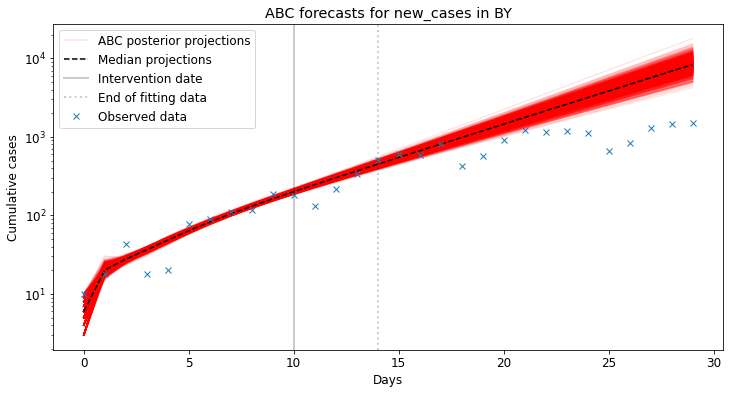

In [39]:
# Plot the simulated data - check it's sensible
df = pd.read_csv('simulated_data/simulated_{}_{}_{}_4day.csv'.format(metric,country, reg, assumed_lag))
start_date = 0
t = np.linspace(0, len(reg_data)-1, len(reg_data))
fig = plt.figure()


for i,x in enumerate(range(num_sims)):
    if i==0:
        plt.plot(pred[x], 'r', alpha=0.1,label='ABC posterior projections')
    else:
        plt.plot(pred[x], 'r', alpha=0.1)
plt.plot(np.median(pred, axis=0), 'k--', label = 'Median projections')
plt.title('ABC forecasts for {} in {}'.format(metric, reg))
plt.ylabel('Cumulative cases'.format(metric))
plt.xlabel('Days')
plt.axvline(x=int_date, linewidth=2, color='k', alpha=0.2, label='Intervention date')
plt.axvline(x=int_date+assumed_lag, linewidth=2, color='k', ls=':', alpha=0.2, label='End of fitting data')
plt.plot(reg_data[metric][start_date:], 'x', label = 'Observed data')
plt.legend()
plt.yscale('log')
#plt.xlim(0, len(reg_data[metric][start_date:]))
#plt.ylim(0,10e3)

#plt.savefig('simulated {} for {}.png'.format(fit_to, reg))
import pickle
with open('plots/DE_{}_{}_ABC.pickle'.format(reg, metric), 'wb') as f: # should be 'wb' rather than 'w'
    pickle.dump(fig, f)

In [40]:
# Do some cleaning up of the dataframe to get rid of unnecessary bits
fit_data = [int(x) for x in reg_data[metric]]
fit_dict = {metric:fit_data}
fit_df = pd.DataFrame.from_dict(fit_dict)
fit_df.to_csv('GP_input_data/{}_{}_{}_4day.csv'.format(country, reg, metric, assumed_lag))

In [389]:
## Check that num observations and num simulated data points are the same!
assert len(pred[0])==len(reg_data[metric][start_date:])

AssertionError: 

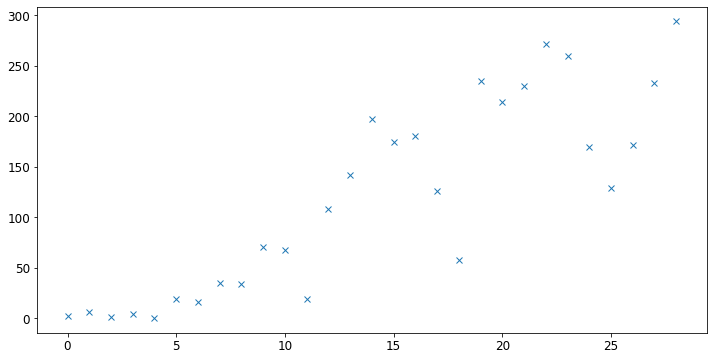

In [390]:
plt.plot(reg_data[metric][start_date:], 'x', label = 'Observed data')

In [391]:
x = ['a', 'b', 'c']
y = ['1','2','3']

In [315]:
 x+y

['a', 'b', 'c', '1', '2', '3']

In [312]:
y

[<generator object <genexpr> at 0x7fe449b34250>]